In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#sns.set(style="ticks")
from scipy import signal
from scipy.optimize import leastsq
from scipy.fft import rfft, rfftfreq
from scipy import signal

from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import math
import csv
from datetime import datetime
from dateutil import parser
from datetime import datetime, timedelta

In [13]:
#ppg
ppg= pd.read_csv('/Users/juliapersche/Desktop/Most_Recent/2_ppg.csv')
ppg = ppg.drop(range(0,5000))
new_timestamps_ppg = []

for idx, row in ppg.iterrows():
     newtime = (row['ts']).astype(str)
     newtime_2 = newtime[:-8]
     new_timestamps_ppg.append(newtime_2)
    
ppg['Timestamp'] = new_timestamps_ppg
ppg['Timestamp'] = ppg['Timestamp'].apply(int)
ppg.drop('ts', axis=1, inplace=True)
    
ppg.head()

,red,ir,green,Timestamp
5000,132033.0,144630.0,12714.0,1679064244
5001,131464.0,146291.0,12491.0,1679064244
5002,130440.0,148970.0,11992.0,1679064244
5003,128147.0,151601.0,11149.0,1679064244
5004,123918.0,151309.0,10107.0,1679064244


In [41]:
#accel
accel= pd.read_csv('/Users/juliapersche/Desktop/Most_Recent/2_accel.csv')

#convert timestamps 
new_timestamps_accel = []

for idx, row in accel.iterrows():
     newtime = (row['ts']).astype(str)
     newtime_2 = newtime[:-8]
     new_timestamps_accel.append(newtime_2)
    
accel['Timestamp'] = new_timestamps_accel
accel['Timestamp'] = accel['Timestamp'].apply(int)

#computing energy (of accel)
accel['x_norm'] = (accel['x'] - accel['x'].mean()) / (accel['x'].max() - accel['x'].min())
accel['y_norm'] = (accel['y'] - accel['y'].mean()) / (accel['y'].max() - accel['y'].min())
accel['z_norm'] = (accel['z'] - accel['z'].mean()) / (accel['z'].max() - accel['z'].min())

accel['energy'] = accel['x_norm']**2 + accel['y_norm']**2 + accel['z_norm']**2



#line up with ppg 
start_timestamp = ppg['Timestamp'].iloc[0]
accel_filtered = accel[accel['Timestamp'] >= start_timestamp]
accel_filtered.drop('ts', axis=1, inplace=True)
accel_filtered.head()




/var/folders/xv/_kt5cgd12jl2mt2z16gq8ryw0000gn/T/ipykernel_1900/2664020074.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accel_filtered.drop('ts', axis=1, inplace=True)


,x,y,z,Timestamp,x_norm,y_norm,z_norm,energy
487,-11.30,6.60,1.89,1679064244,-0.082189,0.198301,0.129436,0.062832
488,-8.92,2.55,-0.42,1679064244,0.045288,0.062668,0.012887,0.006144
489,-11.10,-0.28,-0.96,1679064244,-0.071477,-0.032108,-0.014358,0.006346
490,-9.69,0.91,0.69,1679064244,0.004045,0.007745,0.068891,0.004822
491,-10.06,1.75,0.38,1679064244,-0.015773,0.035876,0.053251,0.004371


In [21]:
PO= pd.read_csv('/Users/juliapersche/Desktop/Most_Recent/2_PO.csv')
EKG= pd.read_csv('/Users/juliapersche/Desktop/Most_Recent/2_EKG.csv')
EKG['Timestamp']  = (pd.to_datetime(EKG['time'])- pd.Timestamp('1970-01-01')).astype('timedelta64[s]').astype('int')


#sync up start time
start_timestamp = ppg['Timestamp'].iloc[0]

#print(start_timestamp)
  
#cut off if off from sensor
PO_filtered = PO[PO['Timestamp'] >= start_timestamp]
EKG_filtered = EKG[EKG['Timestamp'] >= start_timestamp]
        
PO_filtered.drop('Date', axis=1, inplace=True)
PO_filtered.drop('Time', axis=1, inplace=True)
PO_filtered.drop('Session', axis=1, inplace=True)
PO_filtered.drop('Index', axis=1, inplace=True)

EKG_filtered.drop('time', axis=1, inplace=True)

EKG_filtered.head()

/var/folders/xv/_kt5cgd12jl2mt2z16gq8ryw0000gn/T/ipykernel_1900/1011472051.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PO_filtered.drop('Date', axis=1, inplace=True)
/var/folders/xv/_kt5cgd12jl2mt2z16gq8ryw0000gn/T/ipykernel_1900/1011472051.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PO_filtered.drop('Time', axis=1, inplace=True)
/var/folders/xv/_kt5cgd12jl2mt2z16gq8ryw0000gn/T/ipykernel_1900/1011472051.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

,ecg,hr,rr,marker,Timestamp
11901,1.308,NaN,NaN,NaN,1679064244
11902,0.634,NaN,NaN,NaN,1679064244
11903,-0.311,NaN,NaN,NaN,1679064244
11904,-0.415,NaN,NaN,NaN,1679064244
11905,-0.045,NaN,NaN,NaN,1679064244


In [35]:
RR= pd.read_csv('/Users/juliapersche/Desktop/Most_Recent/2_RR.csv')

RR['Timestamp'] = RR['Data Set 1:Time(s)']
RR['Force'] = RR['Data Set 1:Force(N)']
RR['Respiration Rate'] = RR['Data Set 1:Respiration Rate(bpm)']


RR.drop('Data Set 1:Time(s)', axis=1, inplace=True)
RR.drop('Data Set 1:Force(N)', axis=1, inplace=True)
RR.drop('Data Set 1:Respiration Rate(bpm)', axis=1, inplace=True)

RR.head()

,Timestamp,Force,Respiration Rate
0,0.0,3.058189,20.316027
1,0.1,2.649391,NaN
2,0.2,2.197159,NaN
3,0.3,2.092400,NaN
4,0.4,1.995316,NaN


In [79]:
accel_list = accel_filtered['energy'].tolist()
max_value = max(accel_list)

idx_max = accel_list.index(max_value)

print(idx_max)


173


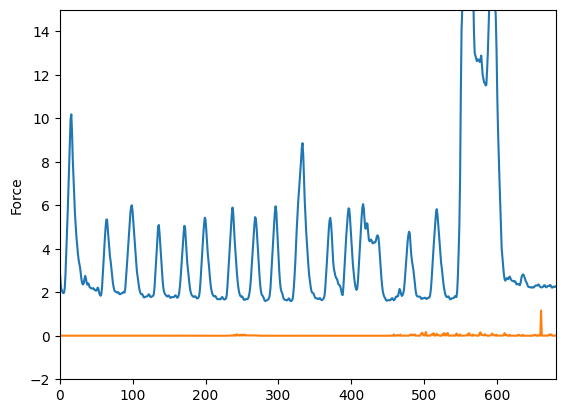

In [62]:
sns.lineplot(data=RR['Force'])
sns.lineplot(data=accel['energy'])
plt.ylim(-2, 15)
plt.xlim(0, 680)


 
plt.show()


In [58]:


print(accel[accel['Timestamp']== energy_peak])

Empty DataFrame
Columns: [ts, x, y, z, Timestamp, x_norm, y_norm, z_norm, energy]
Index: []
